In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import cv2
import PIL.Image as Image
import os
import random
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


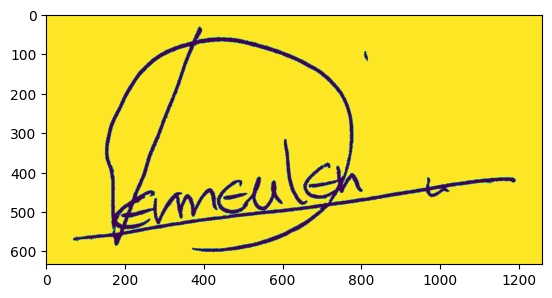

In [3]:
dataset_path = '/content/drive/MyDrive/Dataset_sign'
img = plt.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/00301002.png')
plt.imshow(img)

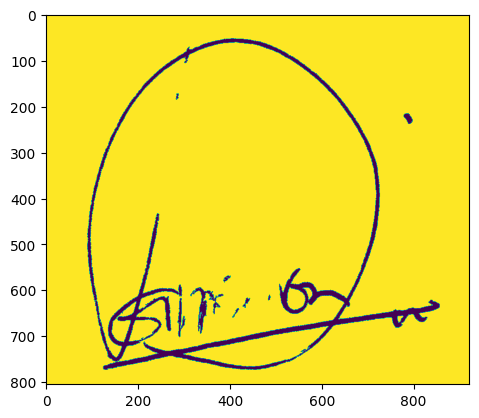

In [4]:
img1 = plt.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/00201002.png')
plt.imshow(img1)

In [5]:
IMAGE_SHAPE = (224,224)
real_signs = [
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset1/real/*.*'),
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset2/real/*.*'),
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset3/real/*.*'),
       glob.glob('/content/drive/MyDrive/Dataset_sign/dataset4/real1/*.*')]

forged_signs = [
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset1/forge/*.*'),
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset2/forge/*.*'),
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset3/forge/*.*'),
        glob.glob('/content/drive/MyDrive/Dataset_sign/dataset4/forge/*.*')
]

In [6]:
training_data=[]
training_labels=[]
testing_data = []
train_paths=[]
testing_labels=[]
test_paths=[]
for data in range(len(real_signs)):
   for it in real_signs[data]:
    image = cv2.imread(it)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(image,IMAGE_SHAPE)
    if data==3:
      test_paths.append(it)
      testing_data.append(resized_img)
      testing_labels.append(0)  #0 stands for real signs
    else:
      train_paths.append(it)
      training_data.append(resized_img)
      training_labels.append(0)
for data in range(len(forged_signs)):
  for it in forged_signs[data]:
    image= cv2.imread(it)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(image,IMAGE_SHAPE)
    if data==3:
      testing_data.append(resized_img)
      test_paths.append(it)
      testing_labels.append(1)  #1 stands for forged signs
    else:
      training_data.append(resized_img)
      train_paths.append(it)
      training_labels.append(1)


In [7]:
training_data = np.array(training_data)
testing_data = np.array(testing_data)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [8]:
training_data = training_data/255.0
testing_data = testing_data/255.0
num_train = sum([len(x) for x in training_data])
num_test = sum([len(x) for x in testing_data])
print(f"Training data length: {num_train}")
print(f"Testing data length: {num_test}")

Training data length: 120960
Testing data length: 40320


In [9]:
def load_images(file_list):
    images = []
    for files in file_list:
        for file in files:
            img = cv2.imread(file)
            images.append(img)
    return images

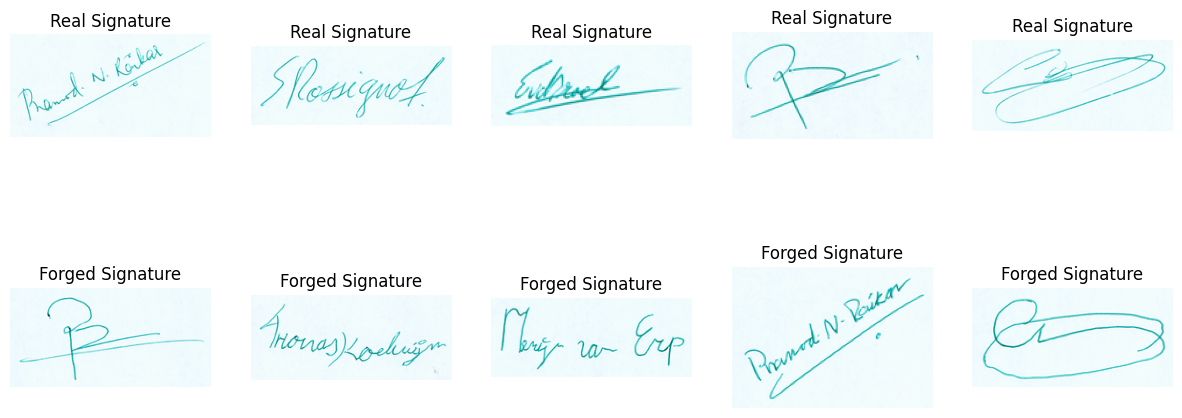

In [10]:
gen_imgs = load_images(real_signs)
forg_imgs = load_images(forged_signs)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(cv2.cvtColor(gen_imgs[i], cv2.COLOR_BGR2RGB))
    axs[0, i].set_title("Real Signature")
    axs[0, i].axis("off")

    axs[1, i].imshow(cv2.cvtColor(forg_imgs[i], cv2.COLOR_BGR2RGB))
    axs[1, i].set_title("Forged Signature")
    axs[1, i].axis("off")

plt.show()

In [11]:
from sklearn.utils import shuffle
training_labels = to_categorical(training_labels)
testing_labels = to_categorical(testing_labels)
training_data,training_labels,train_paths = shuffle(training_data,training_labels,train_paths)
testing_data,testing_labels,test_paths = shuffle(testing_data,testing_labels,test_paths)

In [17]:
model = Sequential()

#Flattening the input
model.add(Flatten(input_shape=(224,224,3)))

#Adding the hidden layers along with dropouts
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2,activation='softmax'))


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               38535424  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                     

In [19]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [20]:
filepath = '/content/model.sav'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
callbacks = [checkpoint]

In [21]:
progress=model.fit(training_data,training_labels,batch_size=16,epochs=50,callbacks=[callbacks],validation_split=0.2)

Epoch 1/50
25/27 [==========================>...] - ETA: 0s - loss: 0.9692 - accuracy: 0.5050
Epoch 1: val_loss improved from inf to 28.30165, saving model to /content/model.sav
27/27 [==============================] - 14s 352ms/step - loss: 0.9543 - accuracy: 0.5046 - val_loss: 28.3016 - val_accuracy: 0.4722
Epoch 2/50
25/27 [==========================>...] - ETA: 0s - loss: 0.8980 - accuracy: 0.5100
Epoch 2: val_loss improved from 28.30165 to 9.20983, saving model to /content/model.sav
27/27 [==============================] - 5s 202ms/step - loss: 0.9179 - accuracy: 0.5046 - val_loss: 9.2098 - val_accuracy: 0.4722
Epoch 3/50
25/27 [==========================>...] - ETA: 0s - loss: 0.8504 - accuracy: 0.5225
Epoch 3: val_loss improved from 9.20983 to 6.59394, saving model to /content/model.sav
27/27 [==============================] - 6s 221ms/step - loss: 0.8540 - accuracy: 0.5185 - val_loss: 6.5939 - val_accuracy: 0.4722
Epoch 4/50
25/27 [==========================>...] - ETA: 0s - lo

In [22]:
model.evaluate(testing_data,testing_labels)

6/6 [==============================] - 0s 12ms/step - loss: 0.8400 - accuracy: 0.6889


[0.8399695754051208, 0.6888889074325562]

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# Assuming testing_labels is one-hot encoded
encoder = LabelEncoder()
encoded_testing_labels = encoder.fit_transform(testing_labels.argmax(axis=1))
pred = model.predict(testing_data)
accuracy = accuracy_score(pred.argmax(axis=1), encoded_testing_labels)

6/6 [==============================] - 0s 12ms/step


In [24]:
pred = np.argmax(pred, axis=1)
test= np.argmax(testing_labels, axis=1)
for i in range(len(test)-100):
  print('Person ',i,' \n Predicted: ',pred[i],' Actual: ',test[i],'path: ',test_paths[i].split('/')[-1])

Person  0  
 Predicted:  1  Actual:  1 path:  02302070.png
Person  1  
 Predicted:  1  Actual:  1 path:  00404024.png
Person  2  
 Predicted:  0  Actual:  0 path:  06305063.png
Person  3  
 Predicted:  1  Actual:  1 path:  03202085.png
Person  4  
 Predicted:  0  Actual:  0 path:  09205092.png
Person  5  
 Predicted:  1  Actual:  1 path:  02304008.png
Person  6  
 Predicted:  1  Actual:  1 path:  00402063.png
Person  7  
 Predicted:  1  Actual:  1 path:  00301002.png
Person  8  
 Predicted:  0  Actual:  1 path:  02303070.png
Person  9  
 Predicted:  1  Actual:  1 path:  00405063.png
Person  10  
 Predicted:  1  Actual:  0 path:  03503035.png
Person  11  
 Predicted:  1  Actual:  1 path:  06105016.png
Person  12  
 Predicted:  0  Actual:  1 path:  01601077.png
Person  13  
 Predicted:  0  Actual:  0 path:  00202002.png
Person  14  
 Predicted:  1  Actual:  0 path:  08503085.png
Person  15  
 Predicted:  1  Actual:  1 path:  00303035.png
Person  16  
 Predicted:  0  Actual:  0 path:  044

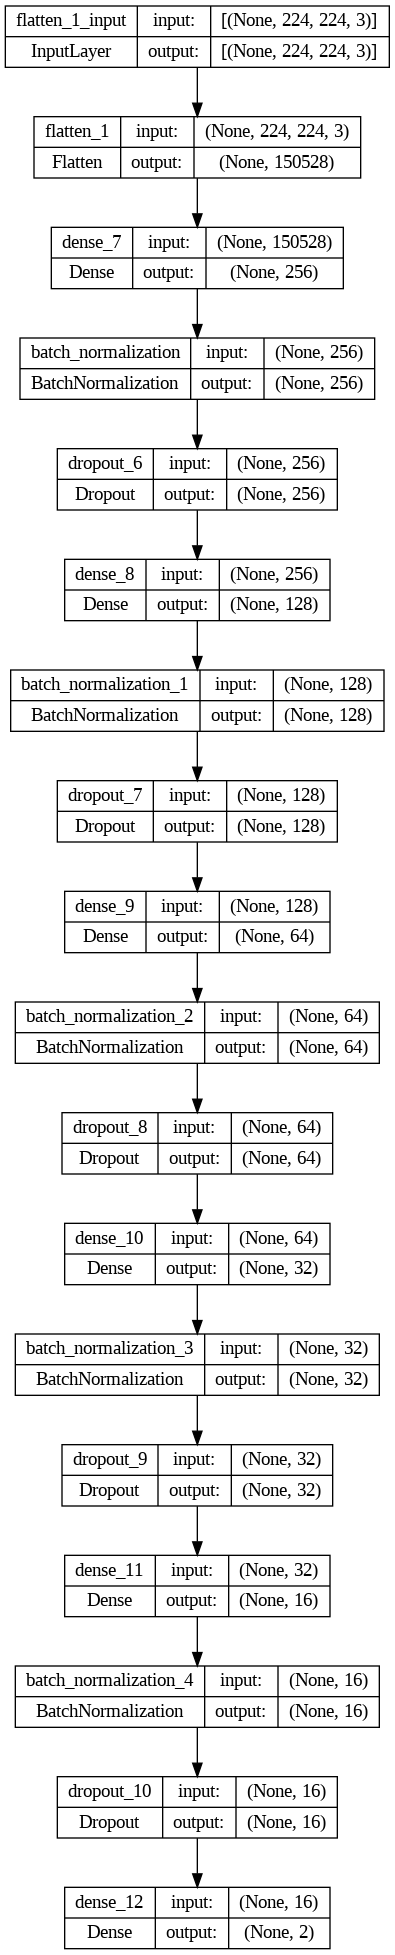

In [25]:
keras.utils.plot_model(model, "ANN_SIGN_Forgery_Detection.png", show_shapes=True)

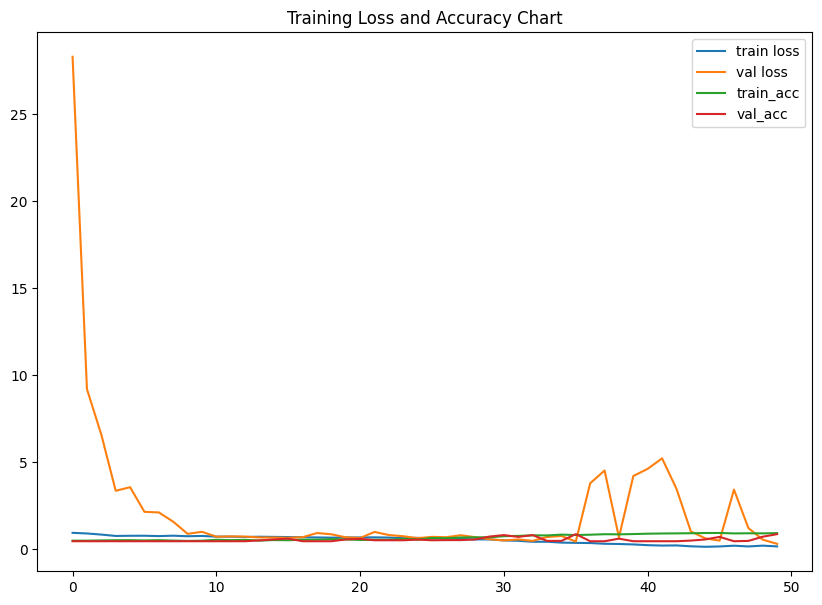

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(10,7))
plt.plot(progress.history['loss'], label='train loss')
plt.plot(progress.history['val_loss'], label='val loss')
plt.plot(progress.history['accuracy'], label='train_acc')
plt.plot(progress.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy Chart")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

In [27]:
from tensorflow.keras.models import load_model
model.save('ann_sign_model.h5')

In [28]:
cur_model = load_model('ann_sign_model.h5')
real_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/real1/04403044.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img,IMAGE_SHAPE)
real_img=real_img/255
real_img = real_img.reshape((1, 224, 224, 3))
predcur=cur_model.predict(real_img)

1/1 [==============================] - 0s 186ms/step


In [29]:
a=np.argmax(model.predict(real_img), axis=1)
if(a==1):
    print("The signature is fraud")
else:
    print("The signature is not fraud")

1/1 [==============================] - 0s 28ms/step
The signature is not fraud


In [30]:
forge_img =cv2.imread('/content/drive/MyDrive/Dataset_sign/dataset4/forge/02302008.png')
forge_img = cv2.cvtColor(forge_img,cv2.COLOR_BGR2RGB)
forge_img = cv2.resize(forge_img,IMAGE_SHAPE)
forge_img=forge_img/255
forge_img = forge_img.reshape((1, 224, 224, 3))
predcur=model.predict(forge_img)

1/1 [==============================] - 0s 19ms/step


In [31]:
a=np.argmax(model.predict(forge_img), axis=1)
if(a==1):
    print("The signature is fraud")
else:
    print("The signature is not fraud")

1/1 [==============================] - 0s 20ms/step
The signature is fraud


6/6 [==============================] - 0s 12ms/step


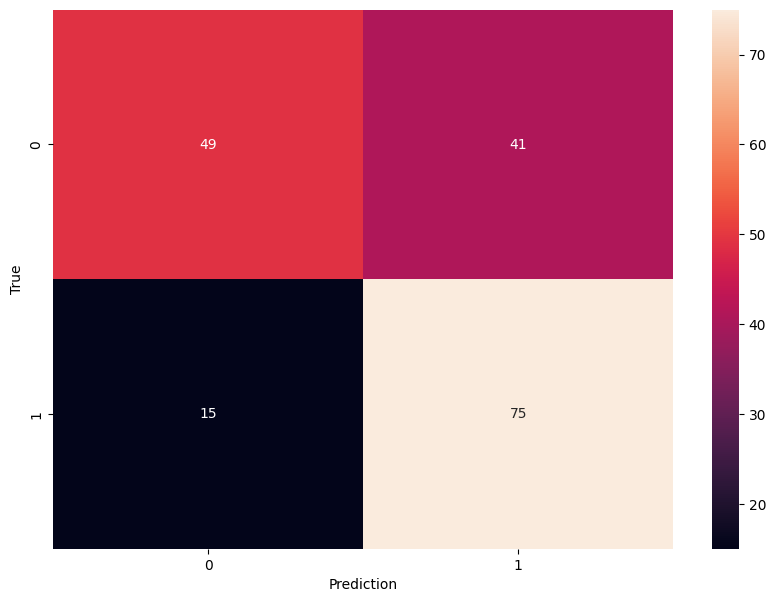

In [32]:
y_predictions =model.predict(testing_data)
y_predictions = [np.argmax(i) for i in y_predictions]
y_actual = [np.argmax(i) for i in testing_labels]
cm = confusion_matrix(y_actual,y_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

In [33]:
print(classification_report(y_actual,y_predictions))

              precision    recall  f1-score   support

           0       0.77      0.54      0.64        90
           1       0.65      0.83      0.73        90

    accuracy                           0.69       180
   macro avg       0.71      0.69      0.68       180
weighted avg       0.71      0.69      0.68       180

